# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd 
from multiprocessing import Pool
from selenium import webdriver
from tqdm import tqdm
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import make_interp_spline

sns.set(font='Franklin Gothic Book',rc={'axes.axisbelow': False,'axes.edgecolor': 'lightgrey','axes.facecolor': 'None','axes.grid': False,'axes.labelcolor': 'dimgrey','axes.spines.right': False,'axes.spines.top': False,'figure.facecolor': 'white','lines.solid_capstyle': 'round','patch.edgecolor': 'w','patch.force_edgecolor': True,'text.color': 'dimgrey','xtick.bottom': False,'xtick.color': 'dimgrey','xtick.direction': 'out','xtick.top': False,'ytick.color': 'dimgrey','ytick.direction': 'out','ytick.left': False,'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":20,"axes.labelsize":18})

---

# Parser

In [4]:
# Assume browser to be chrome
option = webdriver.ChromeOptions()
option.add_argument('--headless')
driver = webdriver.Chrome(options=option)

# Navigate to ercot site with forecasts
driver.get("https://www.ercot.com/mp/data-products/grid/forecasts?id=NP4-737-CD")

# Find all mentions of zip
elem = driver.find_elements_by_xpath("//a[contains(text(),'zip')]")

# And append links to files accordingly
links = []
for link in elem:
    links.append(link.get_attribute('href'))

links = links[::2]

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  # Remove the CWD from sys.path while we load stuff.


In [22]:
for link in links:
    # Get Feb 7
    if '821735392' in link:
        feb7data = pd.read_csv(link,compression='zip')
    # Get Feb 6
    elif '821634498' in link:
        feb6data = pd.read_csv(link,compression='zip') 
    # Get Feb 5
    elif '821459230' in link:
        feb5data = pd.read_csv(link,compression='zip') 
    # Get Feb 4
    elif '821281498' in link:
        feb4data = pd.read_csv(link,compression='zip') 

#### If you do not have Chromium, uncomment and run the following instead to scrape the data

In [23]:
# feb7data = pd.read_csv('https://www.ercot.com/misdownload/servlets/mirDownload?doclookupId=821735392',compression='zip') 
# feb6data = pd.read_csv('https://www.ercot.com/misdownload/servlets/mirDownload?doclookupId=821634498',compression='zip') 
# feb5data = pd.read_csv('https://www.ercot.com/misdownload/servlets/mirDownload?doclookupId=821459230',compression='zip') 
# feb4data = pd.read_csv('https://www.ercot.com/misdownload/servlets/mirDownload?doclookupId=821281498',compression='zip') 

#### Unnecessary, but an example of parallelization of data ingestion as per our conversation

In [6]:
# Csv importer wrapped in a function that can be mapped for parallelization
def read_csv(filename):
    return pd.read_csv(filename,compression='zip')

In [7]:
%%timeit

# Serial approach
# Note the difference in speed between this and the parallelized below
all_data_serial = pd.concat((pd.read_csv(f,compression='zip') for f in links))

The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached.
21 s ± 14.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit

# Set up pool
with Pool(processes=8) as pool: # 8 cores to be safe, on supercomp can run >100 cores

    # Map the file names to df
    df_list = pool.map(read_csv, links)

    # Concat the dataframes to a single
    all_data = pd.concat(df_list, ignore_index=True)

3.03 s ± 1.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

# Analysis

## Figures

In [9]:
# Set up general array for hours in the day
hour_end = feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['HOUR_ENDING']

# Separate the hours into smaller designations for interpolation
hours = np.linspace(hour_end.min(), hour_end.max(), 900)

In [10]:
# Interpolation func, to be used below
def spline(date, df):
    stppf = make_interp_spline(hour_end, df[df.DELIVERY_DATE==date]['STPPF_SYSTEM_WIDE'], k=3)
    actual = make_interp_spline(hour_end, df[df.DELIVERY_DATE==date]['ACTUAL_SYSTEM_WIDE'], k=3)
    return stppf(hours), actual(hours)

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


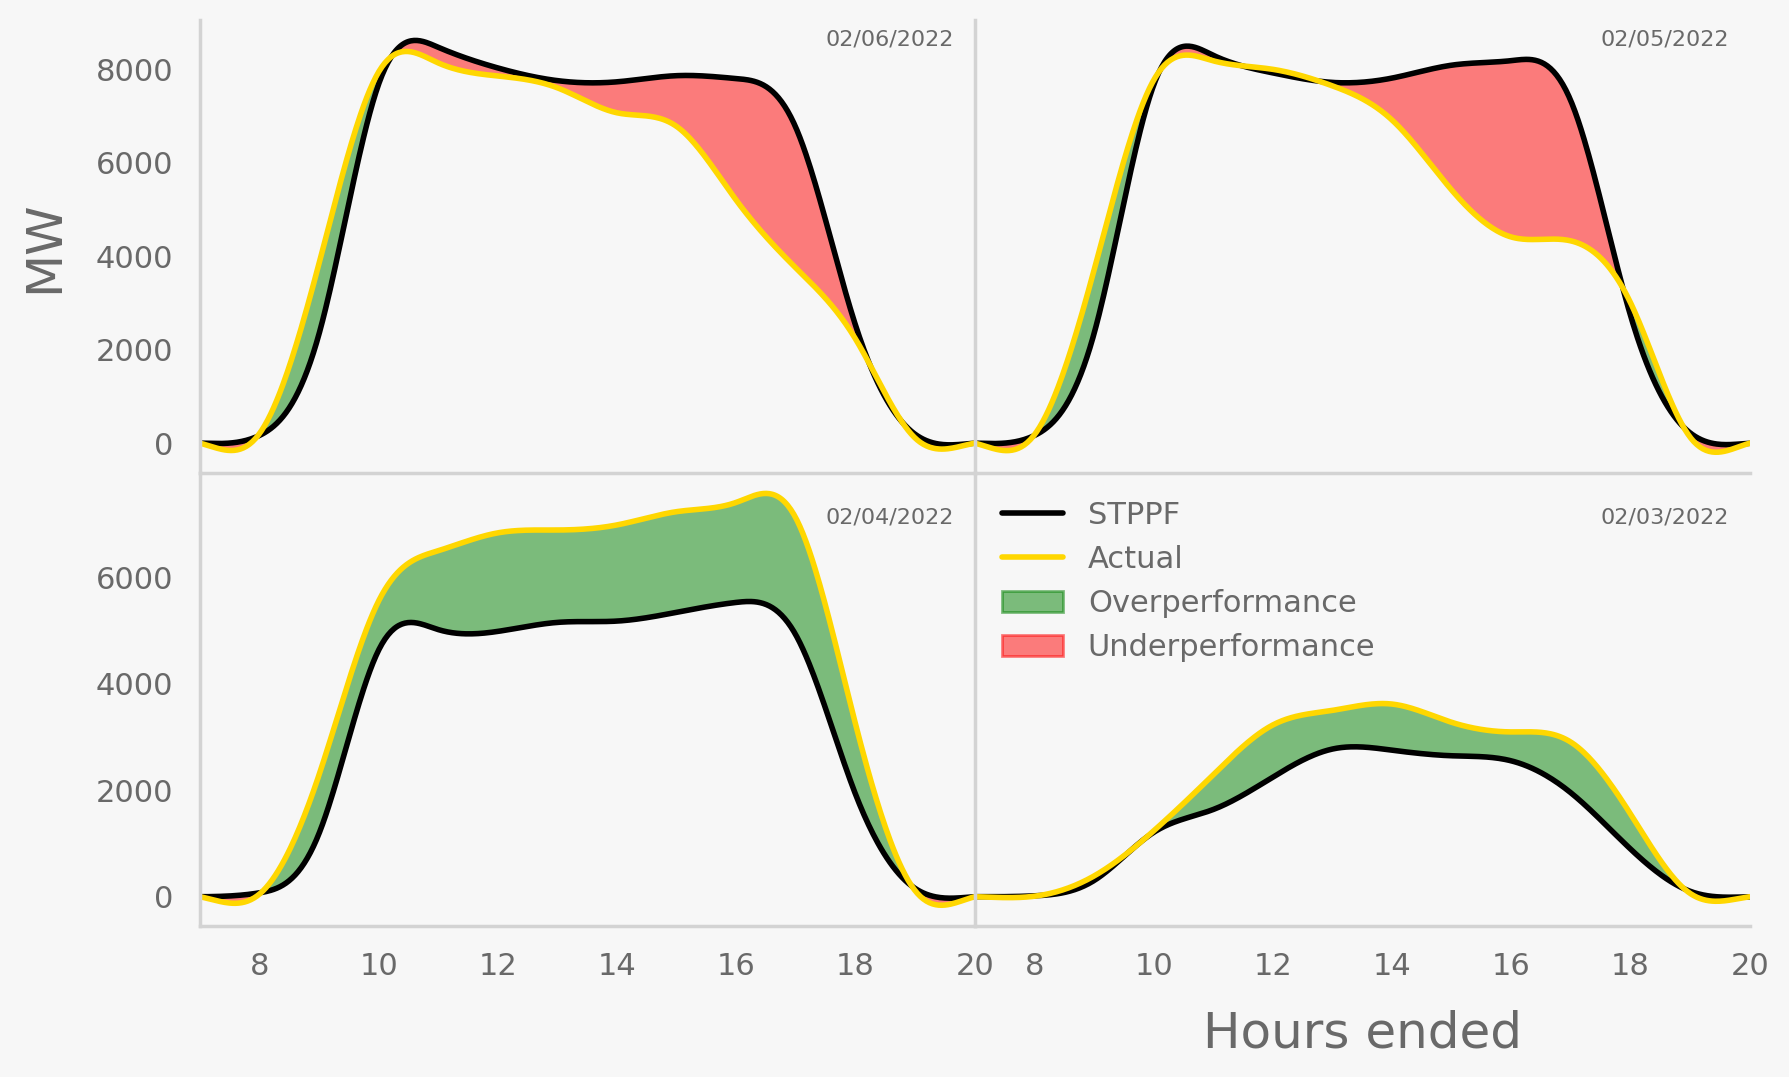

<Figure size 432x288 with 0 Axes>

In [11]:
# Set up figure and grid
fig = plt.figure(figsize=(10,6), facecolor='#f7f7f7', dpi= 200)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')
    
#==================================== ACTUAL VS STPPF FOR 2/6 =============================================

y1, y2 = spline('02/06/2022', feb7data)

ax1.set_xlim(7,20)
ax1.plot(hours, y1, c='black',linewidth=2)
ax1.plot(hours, y2,c='gold',linewidth=2)
ax1.fill_between(hours, y1, y2, where=[(y1[i]<y2[i]) for i in range(len(hours))], interpolate=True, color='green', alpha=0.5)
ax1.fill_between(hours, y1, y2, where=[(y1[i]>y2[i]) for i in range(len(hours))], interpolate=True, color='red', alpha=0.5)
ax1.text(17.5,8500,"02/06/2022",size=8)

#===================================== ACTUAL VS STPPF FOR 2/5 =========================================

y1, y2 = spline('02/05/2022', feb6data)

ax2.set_xlim(7,20)
ax2.plot(hours, y1, c='black',linewidth=2)
ax2.plot(hours, y2,c='gold',linewidth=2)
ax2.fill_between(hours, y1, y2, where=[(y1[i]<y2[i]) for i in range(len(hours))], interpolate=True, color='green', alpha=0.5)
ax2.fill_between(hours, y1, y2, where=[(y1[i]>y2[i]) for i in range(len(hours))], interpolate=True, color='red', alpha=0.5)
ax2.text(17.5,8500,"02/05/2022",size=8)

#===================================== ACTUAL VS STPPF FOR 2/4 =======================================

y1, y2 = spline('02/04/2022', feb5data)

ax3.plot(hours, y1, c='black',linewidth=2)
ax3.plot(hours, y2,c='gold',linewidth=2)
ax3.fill_between(hours, y1, y2, where=[(y1[i]<y2[i]) for i in range(len(hours))], interpolate=True, color='green', alpha=0.5)
ax3.fill_between(hours, y1, y2, where=[(y1[i]>y2[i]) for i in range(len(hours))], interpolate=True, color='red', alpha=0.5)
ax3.text(17.5,7000,"02/04/2022",size=8)

#===================================== ACTUAL VS STPPF FOR 2/3 ========================================

y1, y2 = spline('02/03/2022', feb4data)

ax4.plot(hours, y1, c='black',linewidth=2,label='STPPF')
ax4.plot(hours, y2,c='gold',linewidth=2,label='Actual')
ax4.fill_between(hours, y1, y2, where=[(y1[i]<y2[i]) for i in range(len(hours))], interpolate=True, color='green', alpha=0.5, label='Overperformance')
ax4.fill_between(hours, y1, y2, where=[(y1[i]>y2[i]) for i in range(len(hours))], interpolate=True, color='red', alpha=0.5, label='Underperformance')
ax4.legend(loc=2,frameon=False)
ax4.text(17.5,7000,"02/03/2022",size=8)

#======================================================================================================

ax1.set_ylabel("MW",labelpad=10)
ax4.set_xlabel("Hours ended",labelpad=10)
plt.show()
plt.tight_layout()
fig.savefig('actual_stppf.png')

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


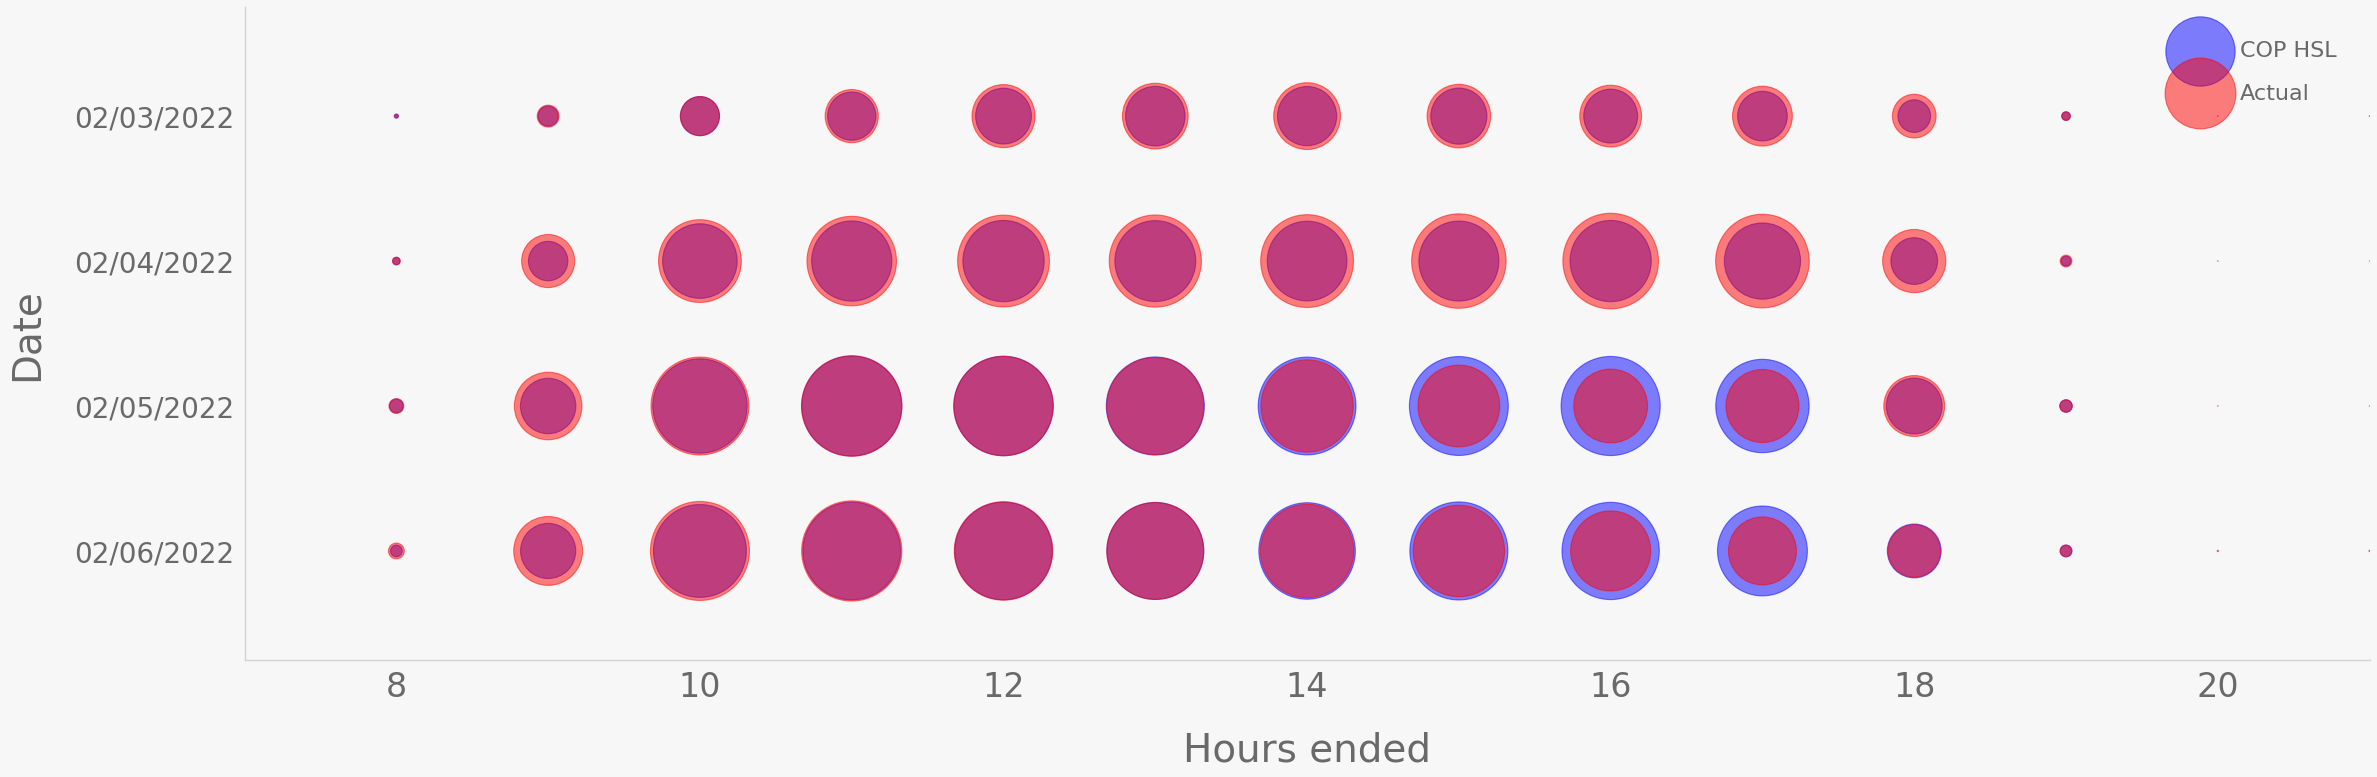

In [12]:
fig, ax = plt.subplots(1,1,figsize=(30,10), facecolor='#f7f7f7', dpi= 80)

#================================ ACTUAL VS COP HSL FOR 2/6 =========================================

plt.scatter(feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['HOUR_ENDING'],
            feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['DELIVERY_DATE'],
            s = feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['COP_HSL_SYSTEM_WIDE'], c='blue',alpha=0.5,
            label="COP HSL")
plt.scatter(feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['HOUR_ENDING'],
            feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['DELIVERY_DATE'],
            s = feb7data[feb7data.DELIVERY_DATE=='02/06/2022']['ACTUAL_SYSTEM_WIDE'], c='red',alpha=0.5,
            label="Actual")

#================================  ACTUAL VS COP HSL FOR 2/5 ==========================================

plt.scatter(feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['HOUR_ENDING'],
            feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['DELIVERY_DATE'],
            s = feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['COP_HSL_SYSTEM_WIDE'], c='blue',alpha=0.5)
plt.scatter(feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['HOUR_ENDING'],
            feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['DELIVERY_DATE'],
            s = feb6data[feb6data.DELIVERY_DATE=='02/05/2022']['ACTUAL_SYSTEM_WIDE'], c='red',alpha=0.5)

#================================  ACTUAL VS COP HSL FOR 2/4 ===========================================

plt.scatter(feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['HOUR_ENDING'],
            feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['DELIVERY_DATE'],
            s = feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['COP_HSL_SYSTEM_WIDE'], c='blue',alpha=0.5)
plt.scatter(feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['HOUR_ENDING'],
            feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['DELIVERY_DATE'],
            s = feb5data[feb5data.DELIVERY_DATE=='02/04/2022']['ACTUAL_SYSTEM_WIDE'], c='red',alpha=0.5)

#================================  ACTUAL VS COP HSL FOR 2/3 ======================================

plt.scatter(feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['HOUR_ENDING'],
            feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['DELIVERY_DATE'],
            s = feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['COP_HSL_SYSTEM_WIDE'], c='blue',alpha=0.5)
plt.scatter(feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['HOUR_ENDING'],
            feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['DELIVERY_DATE'],
            s = feb4data[feb4data.DELIVERY_DATE=='02/03/2022']['ACTUAL_SYSTEM_WIDE'], c='red',alpha=0.5)

#======================================================================================================

plt.xlabel("Hours ended",size=35,labelpad=25)
plt.ylabel("Date",size=35,labelpad=25)
plt.xticks(size=30)
plt.yticks(size=25)
plt.margins(x=0.1,y=0.25)
plt.legend(loc=1,fontsize=20,frameon=False,borderpad=1, labelspacing=1)
plt.xlim(7,21)
plt.tight_layout()
fig.savefig("actual_cop.png",dpi=200)

## Table

In [13]:
# Construct table containing data from Feb 3,4,5,6
table = pd.DataFrame()
table = pd.concat([table,
                   feb7data[feb7data.DELIVERY_DATE=='02/06/2022'],
                   feb6data[feb6data.DELIVERY_DATE=='02/05/2022'],
                   feb5data[feb5data.DELIVERY_DATE=='02/04/2022'],
                   feb4data[feb4data.DELIVERY_DATE=='02/03/2022']],
                   ignore_index=True)

In [14]:
# Drop values not used in the above analysis
table = table.drop('PVGRPP_SYSTEM_WIDE', 1)
table = table.drop('DSTFlag', 1)

In [15]:
# Take rows from sunlight to sunset (roughly)
table = table[(table.HOUR_ENDING > 6) & (table.HOUR_ENDING < 21)]

In [16]:
# Add percent production relative to COP HSL
table['Actual/COP [%]'] = table['ACTUAL_SYSTEM_WIDE']/table['COP_HSL_SYSTEM_WIDE']*100

In [17]:
# Add percent production relative to STPPF
table['Actual/STPPF [%]'] = table['ACTUAL_SYSTEM_WIDE']/table['STPPF_SYSTEM_WIDE']*100

In [18]:
# Clean up presentation of table
table = table.rename(columns={"ACTUAL_SYSTEM_WIDE": "Actual system wide [MW]", 
                      "COP_HSL_SYSTEM_WIDE": "COP HSL system wide [MW]", 
                      "STPPF_SYSTEM_WIDE": "STPPF system wide [MW]",
                      "DELIVERY_DATE": "Delivery date",
                      "HOUR_ENDING": "Hour ending"})
table = table.sort_values(by=['Delivery date','Hour ending']).reset_index(drop=True)

In [19]:
# Output to LaTeX for report
with pd.option_context("max_colwidth", 1000):
  print(table.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} & Delivery date &  Hour ending &  Actual system wide [MW] &  COP HSL system wide [MW] &  STPPF system wide [MW] &  Actual/COP [\%] &  Actual/STPPF [\%] \\
\midrule
0  &    02/03/2022 &            7 &                     0.29 &                       0.0 &                     0.0 &             inf &               inf \\
1  &    02/03/2022 &            8 &                     9.84 &                      14.4 &                    17.1 &       68.333333 &         57.543860 \\
2  &    02/03/2022 &            9 &                   389.51 &                     328.8 &                   303.9 &      118.464112 &        128.170451 \\
3  &    02/03/2022 &           10 &                  1235.58 &                    1240.2 &                  1207.7 &       99.627479 &        102.308520 \\
4  &    02/03/2022 &           11 &                  2290.12 &                    1887.4 &                  1637.1 &      121.337289 &        139.888828 \\
5  &    02/03/2022